In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve 
import numpy as np
import pandas as pd
import io
import string
import os, re, csv, math, codecs
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
import tqdm
from sklearn import model_selection
from sklearn import metrics
import tensorflow as tf  # we use both tensorflow and pytorch (pytorch for main part) , tensorflow for tokenizer
torch.manual_seed(1024);

# 1. Preprocessing

In [95]:
# We define utility functions for text processing.

def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])

def buildDictionary(texts):
    """
    Build the dictionary of words where key is the word and value is the index.
    """
    hashmap = {}
    for text in texts:
        for word in text.split():
            hashmap[word] = hashmap.get(word, 0) + 1
    return {w:i+1 for i, w in enumerate(list(hashmap.keys()))}

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

def lemmatize(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_certain_numbers(text):
    return text.replace('20', ' ')

def merge_two_columns_to_text(text1, text2):
    return text1.split() + text2.loc[0].split()

In [4]:
#load fasttext embeddings
print('loading word embeddings...')
fasttext_embedding = {}
f = codecs.open('C:/datasets/IDMB/fasttext/crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm.tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fasttext_embedding[word] = coefs
f.close()

loading word embeddings...


1999996it [03:54, 8516.02it/s]


In [124]:
# Load the *.csv* file and filter the features that are useful for the problem:
data = pd.read_csv("C:/datasets/nlp-getting-started/train.csv")
sub = pd.read_csv("C:/datasets/nlp-getting-started/test.csv")

In [125]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [126]:
data["keyword"] = data["keyword"].fillna(" ")

In [127]:
sub["keyword"] = sub["keyword"].fillna(" ")

In [128]:
# Text preprocessing. Remove punctuation symbols and stop words:
data["keyword"] = data["keyword"].apply(lambda x: removePunctuation(x))
data["keyword"] = data["keyword"].apply(lambda x: removeStopWords(x))
data["keyword"] = data["keyword"].apply(lambda x: lemmatize(x))
data["keyword"] = data["keyword"].apply(lambda x: remove_certain_numbers(x))
# Text preprocessing. Remove punctuation symbols and stop words:
sub["keyword"] = sub["keyword"].apply(lambda x: removePunctuation(x))
sub["keyword"] = sub["keyword"].apply(lambda x: removeStopWords(x))
sub["keyword"] = sub["keyword"].apply(lambda x: lemmatize(x))
sub["keyword"] = sub["keyword"].apply(lambda x: remove_certain_numbers(x))

In [129]:
# Text preprocessing. Remove punctuation symbols and stop words:
data["text"] = data["text"].apply(lambda x: removePunctuation(x))
data["text"] = data["text"].apply(lambda x: removeStopWords(x))
data["text"] = data["text"].apply(lambda x: lemmatize(x))
# Text preprocessing. Remove punctuation symbols and stop words:
sub["text"] = sub["text"].apply(lambda x: removePunctuation(x))
sub["text"] = sub["text"].apply(lambda x: removeStopWords(x))
sub["text"] = sub["text"].apply(lambda x: lemmatize(x))

In [130]:
data["keyword"].loc[325], "=", (data["keyword"].loc[325].split() + data["text"].loc[325].split())

('armageddon',
 '=',
 ['armageddon',
  'vladimir',
  'putin',
  'issue',
  'major',
  'warning',
  'late',
  'escape',
  'armageddon',
  'httptcogbxafy1m1c'])

In [131]:
data["text"] = (data["keyword"] + " " + data["text"])

In [132]:
sub["keyword"].loc[3241], "=", (sub["keyword"].loc[325].split() + sub["text"].loc[3241].split())

('wrecked',
 '=',
 ['bleeding',
  'cramer',
  'igers',
  '3',
  'word',
  'wrecked',
  'disney',
  'stock',
  'httptco4dgpbaivl7'])

In [133]:
sub["text"] = (sub["keyword"] + " " + sub["text"])

In [134]:
data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [135]:
sub["fake_target"] = -1

In [136]:
data = data[["text", "target"]]
sub = sub[["text", "fake_target"]]

In [137]:
dictionary = buildDictionary(data["text"])
max_seq_len = calculateMaxSeqLen(data["text"])

print(f"Number of words in dictionary: {len(dictionary)}")
print(f"Maximum sequence lenght: {max_seq_len}")

Number of words in dictionary: 21279
Maximum sequence lenght: 26


In [138]:
dictionary = buildDictionary(sub["text"])
max_seq_len = calculateMaxSeqLen(sub["text"])

print(f"Number of words in dictionary: {len(dictionary)}")
print(f"Maximum sequence lenght: {max_seq_len}")

Number of words in dictionary: 11861
Maximum sequence lenght: 24


In [139]:
data["target"].value_counts() / len(data)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [140]:
data

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer...,1
3,13000 people receive wildfire evacuation orde...,1
4,got sent photo ruby alaska smoke wildfire pou...,1
...,...,...
7608,two giant crane holding bridge collapse nearb...,1
7609,ariaahrary thetawniest control wild fire cali...,1
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd...,1
7611,police investigating ebike collided car littl...,1


In [141]:
class TweetDataset:
    def __init__(self, reviews, targets):
        """
        Argument:
        reviews: a numpy array
        targets: a vector array
        
        Return xtrain and ylabel in torch tensor datatype, stored in dictionary format
        """
        self.reviews = reviews
        self.target = targets
    
    def __len__(self):
        # return length of dataset
        return len(self.reviews)
    
    def __getitem__(self, index):
        # given an idex (item), return review and target of that index in torch tensor
        review = torch.tensor(self.reviews[index,:], dtype = torch.long)
        target = torch.tensor(self.target[index], dtype = torch.float)
        
        return {'review': review,
                'target': target}

In [142]:
def create_embedding_matrix(word_index, embedding_dict=None, d_model=100):
    """
     this function create the embedding matrix save in numpy array
    :param word_index: a dictionary with word: index_value
    :param embedding_dict: a dict with word embedding
    :d_model: the dimension of word pretrained embedding, here I just set to 100, we will define again
    :return a numpy array with embedding vectors for all known words
    """
    embedding_matrix = np.zeros((len(word_index) + 1, d_model))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

In [143]:
# STEP 1: Tokenization
# use tf.keras for tokenization,  
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data["text"].values.tolist() + sub["text"].values.tolist())

In [144]:
import itertools

In [145]:
print('Load Glove embedding')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=fasttext_embedding, d_model=300)

Load Glove embedding


In [146]:
embedding_matrix.shape

(27612, 300)

In [147]:
# Split data into training and testing
x_train, x_valid, y_train, y_valid = train_test_split(data["text"], data["target"], test_size=0.2, stratify=data["target"], random_state=42)

In [148]:
x_train.index

Int64Index([6234,  326,  997, 7269, 2189, 3725, 4062, 5928, 5178, 5079,
            ...
            6128,  996, 5011, 3646, 5696, 3386, 3280,  305, 1648, 7569],
           dtype='int64', length=6090)

In [149]:
x_valid.index

Int64Index([4863, 1370, 3521,  178, 5859, 6837, 6167, 2905, 5412, 2227,
            ...
            5970, 6658, 6285, 5783, 7348, 6939, 2074, 3186, 4297, 2344],
           dtype='int64', length=1523)

In [150]:
train_data = pd.concat((x_train, y_train), axis=1).reset_index(drop=True)
valid_data = pd.concat((x_valid, y_valid), axis=1).reset_index(drop=True)
sub_data = sub[["text", "fake_target"]]

In [151]:
xtrain = tokenizer.texts_to_sequences(train_data["text"].values)
xvalid = tokenizer.texts_to_sequences(valid_data["text"].values)
subdata = tokenizer.texts_to_sequences(sub_data["text"].values)

In [152]:
MAX_LEN = 25
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
SUB_BATCH_SIZE = 64

In [153]:
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
xvalid = tf.keras.preprocessing.sequence.pad_sequences(xvalid, maxlen=MAX_LEN)
subdata = tf.keras.preprocessing.sequence.pad_sequences(subdata, maxlen=MAX_LEN)

In [154]:
train_dataset = TweetDataset(reviews=xtrain, targets=train_data["target"].values)

In [155]:
valid_dataset = TweetDataset(reviews=xvalid, targets=valid_data["target"].values)

In [156]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=0)

In [157]:
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=0)

In [158]:
submission_dataset = TweetDataset(reviews=subdata, targets=sub_data["fake_target"].values)

In [159]:
submission_data_loader = torch.utils.data.DataLoader(submission_dataset, batch_size = SUB_BATCH_SIZE, num_workers=0)

In [160]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        """
        Given embedding_matrix: numpy array with vector for all words
        return prediction ( in torch tensor format)
        """
        super(LSTM, self).__init__()
        # Number of words = number of rows in embedding matrix
        num_words = embedding_matrix.shape[0]
        # Dimension of embedding is num of columns in the matrix
        embedding_dim = embedding_matrix.shape[1]
        # Define an input embedding layer
        self.embedding = nn.Embedding(
                                      num_embeddings=num_words,
                                      embedding_dim=embedding_dim)
        # Embedding matrix actually is collection of parameter
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        # Because we use pretrained embedding (GLove, Fastext,etc) so we turn off requires_grad-meaning we do not train gradient on embedding weight
        self.embedding.weight.requires_grad = False
        # LSTM with hidden_size = 128
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(
                            embedding_dim, 
                            hidden_size=512,
                            num_layers=5,
                            dropout=0.6,
                            bidirectional=True,
                            batch_first=True,
                             )
        # Input(512) because we use bi-directional LSTM ==> hidden_size*2 + maxpooling **2  = 128*4 = 512, will be explained more on forward method
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 1)
        
    def forward(self, x):
        # pass input (tokens) through embedding layer
        x = self.embedding(x)
        # fit embedding to LSTM
        hidden, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        # concat avg_pool and max_pool ( so we have 256 size, also because this is bidirectional ==> 256*2 = 512)
        out = torch.cat((avg_pool, max_pool), 1)
        # fit out to self.out to conduct dimensionality reduction from 512 to 1
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        # return output
        return out.squeeze()

In [169]:
device = torch.device('cuda')
# feed embedding matrix to lstm
model = LSTM(embedding_matrix)
# set model to cuda device
model.to(device)
# initialize Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [170]:
print(model)

LSTM(
  (embedding): Embedding(27612, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=5, batch_first=True, dropout=0.6, bidirectional=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)


In [171]:
itr = iter(train_data_loader)

In [172]:
daa = next(itr)

In [173]:
x = daa['review']; x.shape

torch.Size([64, 25])

In [174]:
model(x.cuda()).shape

torch.Size([64])

In [175]:
def calculate_accuracy_with_selected_threshold(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0
    fpr, tpr, thr = roc_curve(grand_truth, predictions)
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
    roc['random'] = roc['fpr'].copy()
    roc['diff'] = roc['tpr'] - roc['fpr']
    roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)
    
    for true, pred in zip(grand_truth, predictions):
        if (pred > roc.loc[0,'thr']) and (true == 1):
            true_positives += 1
        elif (pred < roc.loc[0,'thr']) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

def calculate_accuray_with_point_five(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0    
    for true, pred in zip(grand_truth, predictions):
        if (pred > 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

In [190]:
# # Training
EPOCHS = 5
valid_accuracy_min = 0.831911

for epoch in range(EPOCHS):
#     if epoch > 5:
#         optimizer = optim.Adam(model.parameters(), lr=3e-5)
    model.load_state_dict(torch.load('text_clf_1.pt'))
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    y_train = []
    train_predictions = []
    for data in tqdm.tqdm(train_data_loader, desc=f"training epoch {epoch+1}"):
      
        x = data['review'].type(torch.LongTensor).to(device)
        y = data['target'].type(torch.FloatTensor).to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()
        
        # Save predictions for metrics calculation
        y_train += list(y.cpu().detach().numpy())
        train_predictions += list(y_pred.squeeze().cpu().detach().numpy())
  
    # Evaluation
    with torch.no_grad():
        model.eval()
        y_valid = []
        valid_predictions = []
        for data in tqdm.tqdm(valid_data_loader, desc=f"validation epoch {epoch+1}"):
            x = data['review'].type(torch.LongTensor).to(device)
            y = data['target'].type(torch.FloatTensor).to(device)
           
            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            y_valid += list(y.cpu().detach().numpy())
            valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
            
    train_accuracy = calculate_accuracy_with_selected_threshold(y_train, train_predictions)
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)


    print(f"epoch: {epoch+1}, train_accuracy: {train_accuracy:.5f}, valid_accuracy: {valid_accuracy:.5f}")
    if valid_accuracy >= valid_accuracy_min:
        print('Valid accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_min,valid_accuracy))
        # change the name, for saving multiple files
        torch.save(model.state_dict(), 'text_clf_1.pt')
        valid_accuracy_min = valid_accuracy
        print("=========================================")

validation epoch 1: 100%|██████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.88it/s]


epoch: 1, train_accuracy: 0.85599, valid_accuracy: 0.82928


training epoch 2:  17%|██████████▋                                                     | 16/96 [00:01<00:09,  8.57it/s]


KeyboardInterrupt: 

In [177]:
model.load_state_dict(torch.load('text_clf_1.pt'))

<All keys matched successfully>

In [178]:
with torch.no_grad():
    model.eval()
    valid_predictions = []
    y_valid = []
    for data in tqdm.tqdm(valid_data_loader, desc=f"validation epoch {epoch+1}"):
        x = data['review'].type(torch.LongTensor).to(device)
        y = data['target'].type(torch.FloatTensor).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        y_valid += list(y.cpu().detach().numpy())
        valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
        
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"valid accuracy: {valid_accuracy:.5f}")

validation epoch 18: 100%|█████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.34it/s]

valid accuracy: 0.83191


<AxesSubplot:xlabel='fpr'>

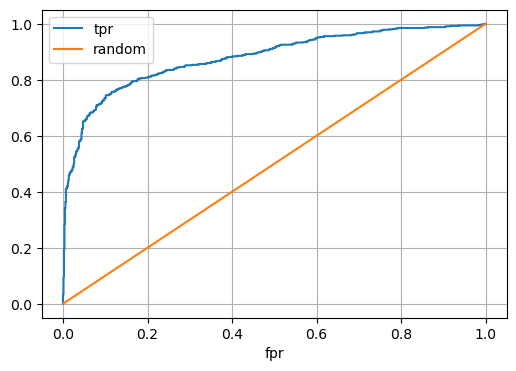

In [179]:
fpr, tpr, thr = roc_curve(y_valid, valid_predictions)
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [180]:
roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)

In [181]:
 roc

,fpr,tpr,thr,random,diff
0,0.101266,0.744648,0.672169,0.101266,0.643382
1,0.115075,0.756881,0.608390,0.115075,0.641806
2,0.110472,0.749235,0.631889,0.110472,0.638764
3,0.108170,0.746177,0.653027,0.108170,0.638007
4,0.112773,0.750765,0.620625,0.112773,0.637991
...,...,...,...,...,...
430,0.994246,0.996942,0.055094,0.994246,0.002696
431,0.000000,0.001529,0.995158,0.000000,0.001529
432,0.000000,0.000000,1.995158,0.000000,0.000000
433,1.000000,1.000000,0.053560,1.000000,0.000000


In [182]:
roc.loc[0,'thr']

0.6721694

In [183]:
len(y_valid), len(valid_predictions)

(1523, 1523)

In [184]:
with torch.no_grad():
    model.eval()
    sub_predictions = []
    for data in tqdm.tqdm(submission_data_loader, desc=f"predictioning"):
        x = data['review'].type(torch.LongTensor).to(device)
        y_pred = model(x)
        sub_predictions += list(y_pred.squeeze().cpu().detach().numpy())

predictioning: 100%|███████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 22.58it/s]


In [185]:
len(sub_predictions)

3263

In [186]:
(np.array(sub_predictions) > roc.loc[0,'thr']).astype("int64")

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [188]:
predictions = (np.array(sub_predictions) > roc.loc[0,'thr']).astype("int64")

sample_sumbission = pd.read_csv('C:/datasets/nlp-getting-started/sample_submission.csv') 

sample_sumbission['target'] = predictions

sample_sumbission.to_csv('C:/datasets/nlp-getting-started/submis1.csv', index=False)

pd.read_csv('C:/datasets/nlp-getting-started/submis1.csv')

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
